In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


In [4]:
n_samples = 15000

def assign_response(severity, crp, bmi, drug):
    # base rule
    if severity >= 4 or crp > 6:
        return "poor complaint"
    elif severity in [2, 3] and crp < 5 and drug in ["NSAID", "Glucosamine"]:
        return "Good Complaint"
    else:
        return "moderate Complaint"

data = []
for _ in range(n_samples):
    age = np.random.randint(40, 85)
    gender = random.choice(["Male", "Female"])
    bmi = round(np.random.uniform(18, 40), 1)
    severity = np.random.randint(1, 5)
    duration = np.random.randint(1, 20)
    crp = round(np.random.uniform(0, 10), 1)
    esr = np.random.randint(0, 100)
    drug = random.choice(["NSAID", "Corticosteroid", "Glucosamine", "Physiotherapy"])
    dosage = random.choice(["Low", "Medium", "High"])
    treat_months = np.random.randint(1, 7)
    activity = random.choice(["Low", "Moderate", "High"])
    diet_score = np.random.randint(1, 11)
    smoke = random.choice(["Yes", "No"])
    alcohol = random.choice(["Yes", "No"])
    
    # assign response
    response = assign_response(severity, crp, bmi, drug)
    
    # Add noise: randomly flip response in ~5% of cases
    if random.random() < 0.05:
        response = random.choice(["Good Complaint", "moderate Complaint", "poor complaint"])
    
    data.append([
        age, gender, bmi, severity, duration, crp, esr, drug,
        dosage, treat_months, activity, diet_score, smoke, alcohol, response
    ])

columns = [
    "Age", "Gender", "BMI", "OA_Severity", "Duration_of_OA", "CRP", "ESR",
    "Drug_Type", "Dosage_Level", "Treatment_Duration", "Activity_Level",
    "Diet_Score", "Smoking_Status", "Alcohol_Consumption", "Response"
]

df = pd.DataFrame(data, columns=columns)
df.to_csv("synthetic_oa_drug_response_noisy.csv", index=False)
print("Dataset created with noise!")
df.head()


Dataset created with noise!


,Age,Gender,BMI,OA_Severity,Duration_of_OA,CRP,ESR,Drug_Type,Dosage_Level,Treatment_Duration,Activity_Level,Diet_Score,Smoking_Status,Alcohol_Consumption,Response
0,55,Male,27.2,4,12,1.1,92,Corticosteroid,Low,4,Low,4,Yes,No,poor complaint
1,51,Female,20.0,2,12,4.1,12,Physiotherapy,High,6,Low,4,Yes,No,moderate Complaint
2,46,Male,32.7,2,9,1.6,11,Physiotherapy,Low,6,High,10,No,Yes,moderate Complaint
3,56,Male,30.1,3,3,8.2,76,Glucosamine,Medium,6,High,7,Yes,Yes,Good Complaint
4,61,Male,29.5,4,17,3.3,11,Corticosteroid,Medium,2,Low,3,Yes,No,poor complaint


In [5]:
# Initialize LabelEncoders
le_dict = {}

categorical_cols = ["Gender", "Drug_Type", "Dosage_Level", "Activity_Level", "Smoking_Status", "Alcohol_Consumption", "Response"]

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le
    # Save encoder
    joblib.dump(le, f"{col.lower()}_label_encoder.pkl")


In [6]:
X = df.drop("Response", axis=1)
y = df["Response"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
etc = ExtraTreesClassifier(n_estimators=200, random_state=42)
etc.fit(X_train, y_train)


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,False
,oob_score,False


Accuracy: 0.9486666666666667

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.86      0.91       429
           1       0.95      0.93      0.94       973
           2       0.95      0.98      0.96      1598

    accuracy                           0.95      3000
   macro avg       0.95      0.92      0.94      3000
weighted avg       0.95      0.95      0.95      3000



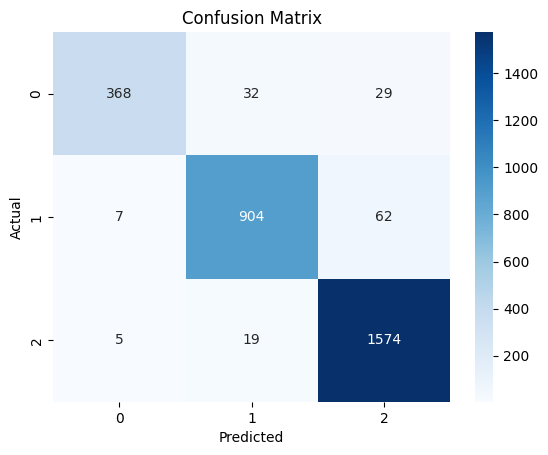

In [8]:
y_pred = etc.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [9]:
# Save model
joblib.dump(etc, "oa_drug_response_extra_tree_model.pkl")

# Save feature names for Streamlit/Flask input mapping
joblib.dump(X.columns.tolist(), "model_features.pkl")
print("Model and features saved successfully!")


Model and features saved successfully!


In [10]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ML models
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


In [11]:
df = pd.read_csv("synthetic_oa_drug_response_noisy.csv")

# Encode categorical columns
cat_cols = ["Gender", "Drug_Type", "Dosage_Level", "Activity_Level", "Smoking_Status", "Alcohol_Consumption", "Response"]
encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le
    joblib.dump(le, f"{col.lower()}_label_encoder.pkl")

# Features and target
X = df.drop("Response", axis=1)
y = df["Response"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
models = {
    "ExtraTrees": ExtraTreesClassifier(n_estimators=200, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=200, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=200, random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42)
}


In [13]:
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    
    print(f"--- {name} ---")
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred))
    print("\n")

# Display comparison
results_df = pd.DataFrame(list(results.items()), columns=["Model", "Accuracy"]).sort_values(by="Accuracy", ascending=False)
print("Model comparison:\n", results_df)


--- ExtraTrees ---
Accuracy: 0.9486666666666667
              precision    recall  f1-score   support

           0       0.97      0.86      0.91       429
           1       0.95      0.93      0.94       973
           2       0.95      0.98      0.96      1598

    accuracy                           0.95      3000
   macro avg       0.95      0.92      0.94      3000
weighted avg       0.95      0.95      0.95      3000



--- RandomForest ---
Accuracy: 0.9633333333333334
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       429
           1       0.96      0.96      0.96       973
           2       0.96      0.99      0.97      1598

    accuracy                           0.96      3000
   macro avg       0.97      0.94      0.95      3000
weighted avg       0.96      0.96      0.96      3000



--- GradientBoosting ---
Accuracy: 0.9633333333333334
              precision    recall  f1-score   support

           0       0.98    

C:\Users\Tejas Krishna\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


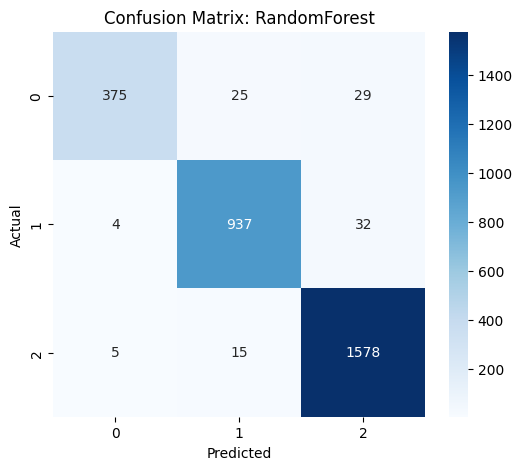

Best model (RandomForest) saved as 'best_oa_drug_response_model.pkl'


In [14]:
best_model_name = results_df.iloc[0]["Model"]
best_model = models[best_model_name]

y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix: {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save best model
joblib.dump(best_model, "best_oa_drug_response_model.pkl")
print(f"Best model ({best_model_name}) saved as 'best_oa_drug_response_model.pkl'")


<Figure size 600x500 with 0 Axes>

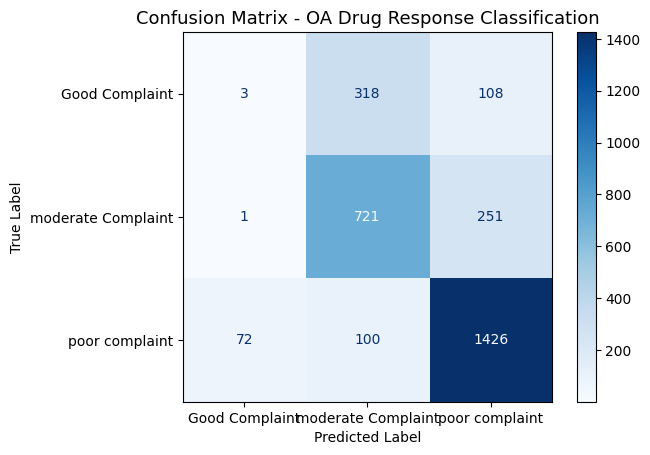

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoders["Response"].classes_)

plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - OA Drug Response Classification", fontsize=13)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
